# Problem Statement
- Build your own recommendation system for products on an e-commerce website like Amazon.com.
 Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to   different users. 
- Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
- In this project we are going to build recommendation model for the electronics products of Amazon. 
 The dataset here is taken from the below website. 
 Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study,  we are using the Electronics dataset.

- Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.



In [135]:
# Load all the required libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import SVD
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from surprise.model_selection import GridSearchCV

In [2]:
os.chdir("D:\Data Science\Great Lakes Project\Recommender Sysem")

In [3]:
colnames=['userId', 'productId', 'ratings', 'timestamp'] 
df = pd.read_csv(r"ratings_Electronics.csv",names=colnames,header=None)

# Data Summary
- We have 4 column in our dataset which contains the userId, productId, ratings and timestamp
- time stamp does not looks be very important which can be ignored
- the data is very huge in dimesions and scales so it very much sparsed dataset

In [4]:
df.shape

(7824482, 4)

In [5]:
df.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


# let's check for any null values in dataset

In [7]:
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [8]:
df.isna().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [9]:
df.drop('timestamp',axis=1,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- We can see that in all there are total 4201696 unique user in our datset
- We can find many of the user whose order count is close to 1 and few user order count is close to 500
- below are the top 10 userId who have maximum number of order on theri names

In [11]:
print("Total unique users -",len(df.userId.unique()))

Total unique users - 4201696


In [12]:
print("Top 10 userId with maximum order")
df.userId.value_counts().head(10)

Top 10 userId with maximum order


A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: userId, dtype: int64

In [13]:
print("Bottom 10 userId with maximum order")
df.userId.value_counts().tail(10)

Bottom 10 userId with maximum order


A9FXB5O4QLGLR     1
A26EWBRRASRQPO    1
A1O0XNLZ7ZY3MP    1
A1B49NNYBWUIHE    1
AHGPPUH6762TE     1
A21OWIV4J5HV0S    1
ADTOXKG4HWP2U     1
A1AKE66Y0R80PP    1
AOXCTKS4G2OOT     1
A205D7O31K95H2    1
Name: userId, dtype: int64

# Count Plot
-  We can notice a most ratings data are at value 5. This is a valuable indicator that points to the skewness of the data. 

[Text(0,0.5,'Count'), Text(0.5,0,'Rating')]

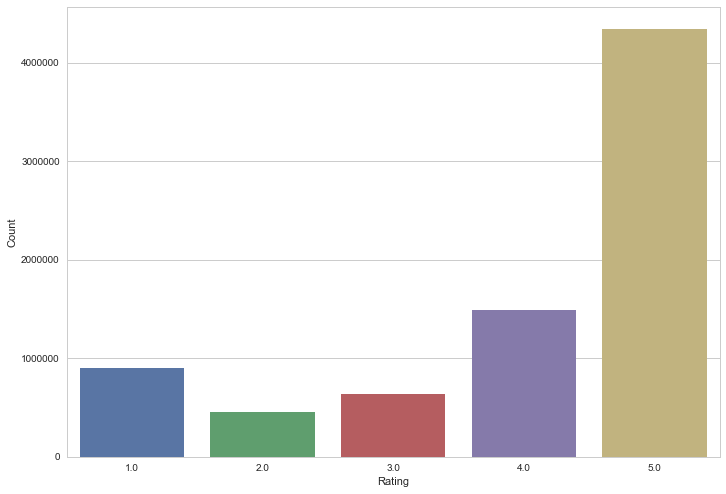

In [14]:
# Rating frequency
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')
ax = sns.countplot(x='ratings', data=df)
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

- Let's take subset of the data to make it less sparse.
- To make it less sparse we will keep only those user whose who has given 50 or more number of ratings

In [42]:
user_count = df.userId.value_counts()

In [43]:
user_50 = user_count.loc[user_count.values >= 50].index
len(user_50)

1540

In [44]:
df_50 = df.loc[df.userId.isin(user_50)]
df_50.shape

(125871, 3)

In [45]:
df_copy = df_50.head(70000)

In [46]:
df_copy.shape

(70000, 3)

# Popularity based recommendation system

# 1. Non personalised poipularity based recommendation system

We will follow below steps to build top -5 electronics product recommendation<br>
a. Let's first take count of user_id for each unique product as recommendation score

b. Sort the product on recommendation score

c. Get the top 5 recommendations

In [47]:
train_data, test_data = model_selection.train_test_split(df_copy, test_size = 0.30, random_state=101)

- First, we will count of userId for each unique productId as recommendation score 
- That score will be used in ranking the products for popularity

In [48]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)

- In order to ranking order let's sort the values in ascending order
- So the highest one will be at the top position

In [35]:
#Sort the product on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
8442,B000N99BBC,115,1.0
17053,B002SZEOLG,82,2.0
16884,B002R5AM7C,81,3.0
17233,B002V88HFE,70,4.0
11885,B0019EHU8G,62,5.0


Now we will Use popularity based recommender model to make predictions and find recommendations for random list of userId's

In [49]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add userId column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    # reposition column so that userId will be at 1st position
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

- Here we clearly see that product recommendation remains same for all the users.
- We are predicting the product based on it's popularity not for perticular user 

In [50]:
find_recom = ['A9FXB5O4QLGLR','AOXCTKS4G2OOT','A3OXHLG6DIBRW8']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A9FXB5O4QLGLR

              userId   productId  score  Rank
8442   A9FXB5O4QLGLR  B000N99BBC    115   1.0
17053  A9FXB5O4QLGLR  B002SZEOLG     82   2.0
16884  A9FXB5O4QLGLR  B002R5AM7C     81   3.0
17233  A9FXB5O4QLGLR  B002V88HFE     70   4.0
11885  A9FXB5O4QLGLR  B0019EHU8G     62   5.0


Here is the recommendation for the userId: AOXCTKS4G2OOT

              userId   productId  score  Rank
8442   AOXCTKS4G2OOT  B000N99BBC    115   1.0
17053  AOXCTKS4G2OOT  B002SZEOLG     82   2.0
16884  AOXCTKS4G2OOT  B002R5AM7C     81   3.0
17233  AOXCTKS4G2OOT  B002V88HFE     70   4.0
11885  AOXCTKS4G2OOT  B0019EHU8G     62   5.0


Here is the recommendation for the userId: A3OXHLG6DIBRW8

               userId   productId  score  Rank
8442   A3OXHLG6DIBRW8  B000N99BBC    115   1.0
17053  A3OXHLG6DIBRW8  B002SZEOLG     82   2.0
16884  A3OXHLG6DIBRW8  B002R5AM7C     81   3.0
17233  A3OXHLG6DIBRW8  B002V88HFE     70   4.0
11885  A3OXHLG6DIBRW8  B0019EHU8G 

C:\Users\tdhqv8\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Content Based recomendation Systems

In [51]:
reader = Reader(rating_scale =(1,5))

In [141]:
data = Dataset.load_from_df(df_copy[['userId','productId','ratings']],reader)

In [54]:
# Split data to train and test
trainset, testset = train_test_split(data,test_size=0.30, random_state=101)

In [55]:
trainset

In [56]:
# user item rating data can be obtained as follows
user_records = trainset.ur
type(user_records)

collections.defaultdict

In [57]:
# However the ids are the inner ids and not the raw ids
# raw ids can be obatined as follows
print(trainset.to_raw_uid(0))
print(trainset.to_raw_iid(1065))

A2PY5ED630H0QJ
B0012845AA


# Training the model
- KNNWithMeans model is giving high RMSE for item based similarity model
- KNNWithMeans model is giving little lower RMSE for user based similarity model

In [98]:
KNN_item = KNNWithMeans(k=50,sim_options={'name':'cosine','shrinkage': 0.3,'user_based':False})
KNN_item.fit(trainset)
# Evalute on test set
testet_pred = KNN_item.test(testset)
# compute RMSE
accuracy.rmse(testet_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.


RMSE: 1.1922


1.1921575176872556

In [88]:
testet_pred[5]

Prediction(uid='A10PEXB6XAQ5XF', iid='B001CBLN7K', r_ui=4.0, est=4.45, details={'actual_k': 1, 'was_impossible': False})

In [103]:
KNN_user = KNNWithMeans(k=50,sim_options={'name':'cosine','shrinkage': 0.3,'user_based':True})
KNN_user.fit(trainset)
testetuser_pred = KNN_user.test(testset)
# compute RMSE
accuracy.rmse(testetuser_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.


RMSE: 1.1205


1.1204949921092915

In [104]:
testetuser_pred[5]

Prediction(uid='A10PEXB6XAQ5XF', iid='B001CBLN7K', r_ui=4.0, est=4.455486542443063, details={'actual_k': 1, 'was_impossible': False})

# Predicting the top 5 results

In [100]:
testset_new = trainset.build_anti_testset()

In [101]:
len(testset_new)

35885360

In [102]:
testset_new[0:5]

[('A2PY5ED630H0QJ', 'B0030H4I5I', 4.259204081632653),
 ('A2PY5ED630H0QJ', 'B0031GGQC6', 4.259204081632653),
 ('A2PY5ED630H0QJ', 'B0007R4LI8', 4.259204081632653),
 ('A2PY5ED630H0QJ', 'B000VCHII4', 4.259204081632653),
 ('A2PY5ED630H0QJ', 'B00274HQY0', 4.259204081632653)]

In [105]:
predictions = KNN_user.test(testset_new[0:10000])

In [106]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est,] for x in predictions])

In [107]:
predictions_df.columns = ["userId",'productId',"rating"]
predictions_df.sort_values(by = ["userId", "rating"],ascending=False,inplace=True)

In [108]:
predictions_df.head()

,userId,productId,rating
31,A2PY5ED630H0QJ,B000NGTKOI,5.0
42,A2PY5ED630H0QJ,B000K9FFA6,5.0
80,A2PY5ED630H0QJ,B0012S4APK,5.0
104,A2PY5ED630H0QJ,B003X7TRWE,5.0
141,A2PY5ED630H0QJ,B0002WPREU,5.0


In [109]:
top_5_records = predictions_df.groupby("userId").head().reset_index(drop=True)

In [110]:
top_5_records

,userId,productId,rating
0,A2PY5ED630H0QJ,B000NGTKOI,5.0
1,A2PY5ED630H0QJ,B000K9FFA6,5.0
2,A2PY5ED630H0QJ,B0012S4APK,5.0
3,A2PY5ED630H0QJ,B003X7TRWE,5.0
4,A2PY5ED630H0QJ,B0002WPREU,5.0


# SVD Based Recommendation

In [140]:
svd = SVD(n_factors=5,reg_all= 0.02)
svd.fit(trainset)
test_pred = svd.test(testset)
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.0269


1.0269139057991297

# Hyper Parameter tuning of SVD Recommendation system

In [136]:
param_grid = {'n_factors':[5,10,15,20],'reg_all':[0.01,0.02]}
gs = GridSearchCV(SVD,param_grid,measures=['rmse'], cv=5,refit = True)

In [137]:
gs.fit(data)
print(gs.best_params)

{'rmse': {'n_factors': 5, 'reg_all': 0.02}}


# Summary:
- The dataset very highly sparse model.
- After taking subset of the data it looks like less items are available so getting very high RMSE value
- After taking the subset of data, datset has become unfit for mostly item based recommendation system
- Also the dataset rating count plot shows that there are many items have given ratings as 5 which are is giving biased result so high RMSE